In [1]:
import polybinderCG as cg
import signac
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd

from cmeutils.plotting import get_histogram
import matplotlib.cm as cm

In [2]:
aa_project = signac.get_project("../../ua-target-runs/tm_sweep")
cg_project = signac.get_project("../../coarse-grain-sims/tm_ti_sweep/nvt-runs/")

In [4]:
for job in aa_project:
    if not job.isfile("components.gsd"):
        print(job, print(job.doc.done))

False
d78d30bb416dc0c6ed8a51d0e9a886bf None
False
e0565bee3783ac8beea6cdc873b39c3d None


In [23]:
list(aa_project.detect_schema()["kT_quench"][float])

[2.5,
 3.5,
 4.7,
 5.5,
 4.1,
 6.2,
 3.0,
 4.5,
 4.3,
 3.8,
 5.0,
 6.0,
 7.0,
 6.3,
 4.0,
 5.9,
 6.1,
 6.5,
 4.2]

In [24]:
kT = 3.0
aa_job = [job for job in aa_project.find_jobs({"kT_quench": kT, "para_weight": 1.0})][0]
cg_job = [job for job in cg_project.find_jobs({"kT_quench": kT, "ekk_weight": 1.0})][0]

In [25]:
aa_speeds = []
cg_speeds = []
with gsd.hoomd.open(aa_job.fn("components.gsd")) as aa_traj:
    with gsd.hoomd.open(cg_job.fn("sim_traj.gsd")) as cg_traj:
        for i in range(50):
            frame = -(i + 1)
            aa_speeds.extend(list(np.linalg.norm(v) for v in aa_traj[frame].particles.velocity))
            cg_speeds.extend(list(np.linalg.norm(v) for v in cg_traj[frame].particles.velocity))

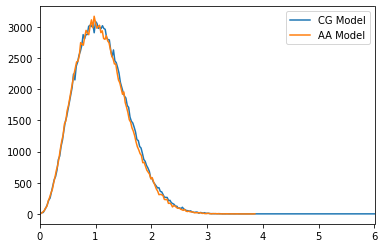

In [26]:
fig = plt.figure()
cg_x, cg_y = get_histogram(cg_speeds)
aa_x, aa_y = get_histogram(aa_speeds)

plt.plot(cg_x, cg_y, label="CG Model")
plt.plot(aa_x, aa_y, label="AA Model")
plt.xlim(0, 6)
plt.legend()
plt.show()

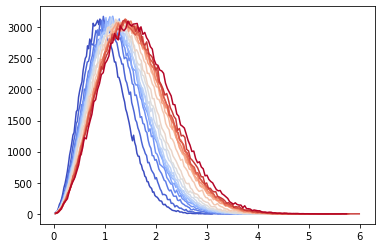

In [8]:
gradient = cm.get_cmap('coolwarm', len(list(aa_project.detect_schema()["kT_quench"][float])))
newcolors = gradient(np.linspace(0, 1, len(list(aa_project.detect_schema()["kT_quench"][float]))))

count = 0
avg_aa_speeds = []
aa_temp = []

for kT, job in aa_project.find_jobs({"para_weight": 1.0}, doc_filter={"done": True}).groupby("kT_quench"):
    job = list(job)[0]
    aa_speeds = []
    with gsd.hoomd.open(job.fn("components.gsd")) as traj:
        for snap in traj[-50:]:
            aa_speeds.extend([np.linalg.norm(v) for v in snap.particles.velocity])
    
    x, y = get_histogram(aa_speeds)
    plt.plot(x, y, label=kT, c=newcolors[count])
    avg_aa_speeds.append(np.mean(aa_speeds))
    aa_temp.append(kT)
    count += 1
#plt.legend()
plt.show()

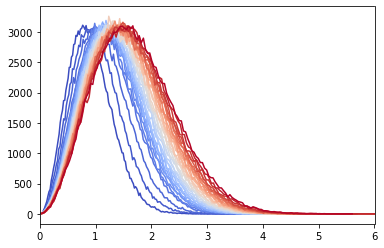

In [7]:
gradient = cm.get_cmap('coolwarm', len(list(cg_project.detect_schema()["kT_quench"][float])))
newcolors = gradient(np.linspace(0, 1, len(list(cg_project.detect_schema()["kT_quench"][float]))))

avg_cg_speeds = []
cg_temp = []

count = 0
for kT, job in cg_project.find_jobs({"ekk_weight": 1.0,}, doc_filter={"done": True}).groupby("kT_quench"):
    job = list(job)[0]
    cg_speeds = []
    with gsd.hoomd.open(job.fn("sim_traj.gsd")) as traj:
        for snap in traj[-50:]:
            cg_speeds.extend([np.linalg.norm(v) for v in snap.particles.velocity])
    
    x, y = get_histogram(cg_speeds)
    plt.plot(x, y, label=kT, c=newcolors[count])
    avg_cg_speeds.append(np.mean(cg_speeds))
    cg_temp.append(kT)
    count += 1

plt.xlim(0, 6)
plt.show()

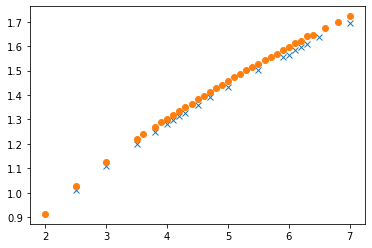

In [9]:
plt.plot(aa_temp, avg_aa_speeds, "x")
plt.plot(cg_temp, avg_cg_speeds, "o")

In [10]:
kT = 6.0
aa_job = [job for job in aa_project.find_jobs({"kT_quench": kT, "para_weight": 1.0})][0]
cg_job = [job for job in cg_project.find_jobs({"kT_quench": kT, "ekk_weight": 1.0})][0]

In [11]:
indices = np.arange(500, 10100, (10100 - 500)//1000)

In [17]:
aa_energy = np.zeros_like(indices)

aa_data = np.genfromtxt(aa_job.fn("sim_traj.txt"), names=True)
cg_data = np.genfromtxt(cg_job.fn("sim_traj.txt"), names=True)

aa_total_energy = total_energy_aa(aa_data, indices) / 3000
cg_total_energy = total_energy_cg(cg_data, indices) / 3000

aa_x, aa_y = get_histogram(aa_total_energy)
cg_x, cg_y = get_histogram(cg_total_energy)

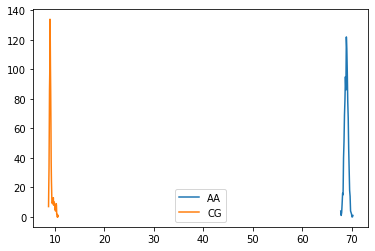

In [18]:
fig = plt.figure()
plt.plot(aa_x, aa_y, label="AA")
plt.plot(cg_x, cg_y, label="CG")

plt.legend()

In [ ]:
np.zeros((4)).dtype

In [16]:
def total_energy_cg(data_array, indices):
    total = np.zeros(indices.shape)
    
    headers = [
        #'mdcomputeThermodynamicQuantitiespotential_energy',
        'mdcomputeThermodynamicQuantitieskinetic_energy',
        #'mdpairTableenergy',
        #'mdbondTableenergy',
        #'mdangleTableenergy',
        #'mddihedralHarmonicenergy'
    ]
    for h in headers:
        total += data_array[h][indices]
    return total

def total_energy_aa(data_array, indices):
    total = np.zeros(indices.shape)
    
    headers = [
        #'mdcomputeThermodynamicQuantitiespotential_energy',
        'mdcomputeThermodynamicQuantitieskinetic_energy',
        #'mdpairLJenergy',
        #'mdpairEwaldenergy',
        #'mdlong_rangepppmCoulombenergy',
        #'mdspecial_pairLJenergy',
        #'mdspecial_pairCoulombenergy',
        #'mdbondHarmonicenergy',
        #'mdangleHarmonicenergy',
        #'mddihedralHarmonicenergy'
    ]
    for h in headers:
        total += data_array[h][indices]
    return total

In [ ]:
list(aa_data.dtype.fields.keys())

In [ ]:
aa_data["mdcomputeThermodynamicQuantitieskinetic_energy"]

In [ ]:
fig = plt.figure()
cg_x, cg_y = get_histogram(cg_speeds)
aa_x, aa_y = get_histogram(aa_speeds)

plt.plot(cg_x, cg_y, label="CG Model")
plt.plot(aa_x, aa_y, label="AA Model")
plt.xlim(0, 6)
plt.legend()
plt.show()